In [96]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
import os
from bs4 import BeautifulSoup

a. Image processing
==
1. Resizing method

Observations and experimentation:
64x64 as first pass
first image as 4 as 3rd param. (RGBA: transparency. need to see how to drop it, convert to rgb isn't enough)
8th image no 3rd param.
does not contain apple_34.
consider:
* kernel_size
* image augmentation: imageDataGen & cutMix, Mix
* colab -> GPU

observations for imgDataGen:
increasing batch-size from 1 to 5 greatly improves accuracy
batch size of 32, poor accuracy
change epochs from 100 to 500 has poorer result

In [104]:
from os.path import isfile
import glob

curr_dir = os.getcwd()
train_path = curr_dir + "/train/"
test_path = curr_dir + "/test/"
class_names = ["apple", "banana", "mixed", "orange"]

files_train = [img for img in glob.glob(train_path + "*.jpg")]
files_test = [img for img in glob.glob(test_path + "*.jpg")]
files_train_xml = [img for img in glob.glob(train_path + "*.xml", recursive = True)]
files_test_xml = [img for img in glob.glob(test_path + "*.xml", recursive = True)]

In [105]:
def PreProcessXML(files):

    data_crop_xml = []
    for file in files:
        with open(file) as f:
            data = f.read()

        Bs_data = BeautifulSoup(data, 'html.parser')

        x_min = min([int(item.get_text()) for item in Bs_data.find_all('xmin')])
        x_max = max([int(item.get_text()) for item in Bs_data.find_all('xmax')])
        y_min = min([int(item.get_text()) for item in Bs_data.find_all('ymin')])
        y_max = max([int(item.get_text()) for item in Bs_data.find_all('ymax')])

        x_y_data = [x_min,y_max,x_max,y_min]
        data_crop_xml.append(x_y_data)

    return data_crop_xml

data_train_crop_xml = PreProcessXML(files_train_xml)
data_test_crop_xml = PreProcessXML(files_test_xml)
print(data_train_crop_xml)

[[15, 291, 255, 87], [5, 276, 287, 31], [234, 343, 416, 132], [1, 250, 224, 1], [121, 354, 514, 93], [23, 265, 272, 33], [96, 397, 580, 107], [26, 295, 300, 28], [76, 439, 759, 58], [254, 720, 617, 231], [24, 398, 600, 1], [99, 416, 670, 8], [87, 415, 603, 127], [57, 459, 615, 239], [125, 374, 363, 144], [133, 595, 725, 115], [97, 326, 366, 62], [36, 282, 271, 38], [3, 263, 342, 61], [4, 434, 409, 92], [140, 688, 965, 61], [4, 398, 366, 71], [117, 175, 489, 81], [17, 201, 421, 57], [79, 282, 596, 32], [19, 708, 719, 1], [291, 342, 588, 55], [6, 206, 206, 18], [56, 332, 413, 98], [67, 155, 222, 8], [125, 497, 772, 133], [159, 336, 520, 45], [4, 926, 1818, 3], [10, 4515, 2466, 625], [24, 235, 253, 11], [86, 290, 422, 12], [184, 525, 582, 110], [92, 522, 546, 66], [26, 239, 222, 56], [46, 514, 770, 59], [31, 222, 157, 82], [344, 394, 640, 76], [1, 810, 651, 132], [71, 220, 258, 18], [97, 320, 533, 83], [1, 676, 532, 171], [130, 1800, 1071, 621], [193, 983, 1700, 207], [75, 328, 563, 21], 

In [106]:
x_resize = 224
y_resize = 224


Run only if not using XML.
==

In [112]:
# TODO: write a function to create the directory automatically,
# if dir exists, do not create the dir..
def process_image(files, path, method):
    x = None
    y = []
    for i in range(len(files)):
        img = Image.open(files[i])
        img_resize = img.resize((x_resize, y_resize))
        if img_resize.mode in ["RGBA", "P"]:
            img_resize = img_resize.convert("RGB")
        if x is None:
            x = img_resize
        else:
            x = np.concatenate((x, img_resize))
        y.append(os.path.basename(files[i]).split('_')[0])
        img_name = os.path.basename(files[i]).split('.')[0]
        save_path = path + "resize/" + img_name
        save_image(img_resize, method, save_path)

    #x = x.reshape(-1, x_resize, y_resize, 3)
    le = LabelEncoder()
    y = le.fit_transform(y)

    return x,y

def save_image(img, method, save_path):
    if method == 'resize':
        img.save(save_path + "_{}x{}.jpg".format(x_resize, y_resize))
    if method == 'image_data_gen':
        img.save(save_path + "idg.jpg")

In [114]:
x_train, y_train = process_image(files_train, train_path, 'resize')
x_test, y_test = process_image(files_test, test_path, 'resize')
x_test

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[244, 244, 252],
        [244, 244, 252],
        [244, 244, 252],
        ...,
        [244, 244, 252],
        [244, 244, 252],
        [244, 244, 252]],

       [[244, 244, 252],
        [244, 244, 252],
        [244, 244, 252],
        ...,
        [244, 244, 252],
        [244, 244, 252],
        [244, 244, 252]],

       [[244, 244, 252],
        [244, 244, 252],
        [244, 244, 252],
        ...,
        [244, 244, 252],
        [244, 244, 252],
        [244, 244, 252]]

Run if using XML.
==

In [198]:
resize_x = 64
resize_y = 64
number_of_labels = 4
def PreProcess(files, istrain):
    x_res = None
    y_res = []

    for i in range(0, len(files)):
        img_raw = Image.open(files[i])
        # width,height = img_raw.size
        if istrain :
            img_raw = img_raw.crop((data_train_crop_xml[i][0],data_train_crop_xml[i][3],data_train_crop_xml[i][2],data_train_crop_xml[i][1]))
        else:
            img_raw = img_raw.crop((data_test_crop_xml[i][0],data_test_crop_xml[i][3],data_test_crop_xml[i][2],data_test_crop_xml[i][1]))
        img_tiny = img_raw.resize((resize_x, resize_y))
        if img_tiny.mode == 'RGBA' or img_tiny.mode == 'P':
            img_tiny = img_tiny.convert('RGB')
        if x_res is None:
            x_res = img_tiny
        else:
            x_res = np.concatenate((x_res, img_tiny))
        y_res.append(os.path.basename(files[i]).split('_')[0])
#        if istrain:
#             angle = 90
#             inc = 3
#             for j in range(inc):
#                    new_angle = (j+1)*angle
#                    new_img = img_tiny.rotate(new_angle)
#                    x_res = np.concatenate((x_res, new_img))
#                    y_res.append(os.path.basename(files[i]).split('_')[0])

    x_res = x_res.reshape(-1, resize_x, resize_y, 3)
    le = LabelEncoder()
    le.fit(y_res)
    y_res = le.transform(y_res)
    y_res = tf.keras.utils.to_categorical(y_res, number_of_labels)
    # print(le.classes_)
    # print(y_res)
    return x_res , y_res

x_train,y_train = PreProcess(files_train,True)
x_test,y_test = PreProcess(files_test,False)

In [114]:
files_resize_train = [img for img in glob.glob(train_path + "/resize/" + "*.jpg")]
files_resize_test = [img for img in glob.glob(test_path + "/resize/" + "*.jpg")]


In [115]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(240, 64, 64, 3)
(60, 64, 64, 3)
(240, 4)
(60, 4)


In [49]:
# preview of images
def plot_summary_view(is_train):
    if is_train:
        x = x_train
        y = y_train
    else:
        x = x_test
        y = y_test

    plt.figure(figsize=(20,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.grid(False)
        plt.imshow(x[i])
        # plt.title(class_names[y[i]])
        plt.title(class_names[np.argmax(y[i])])
    plt.show()

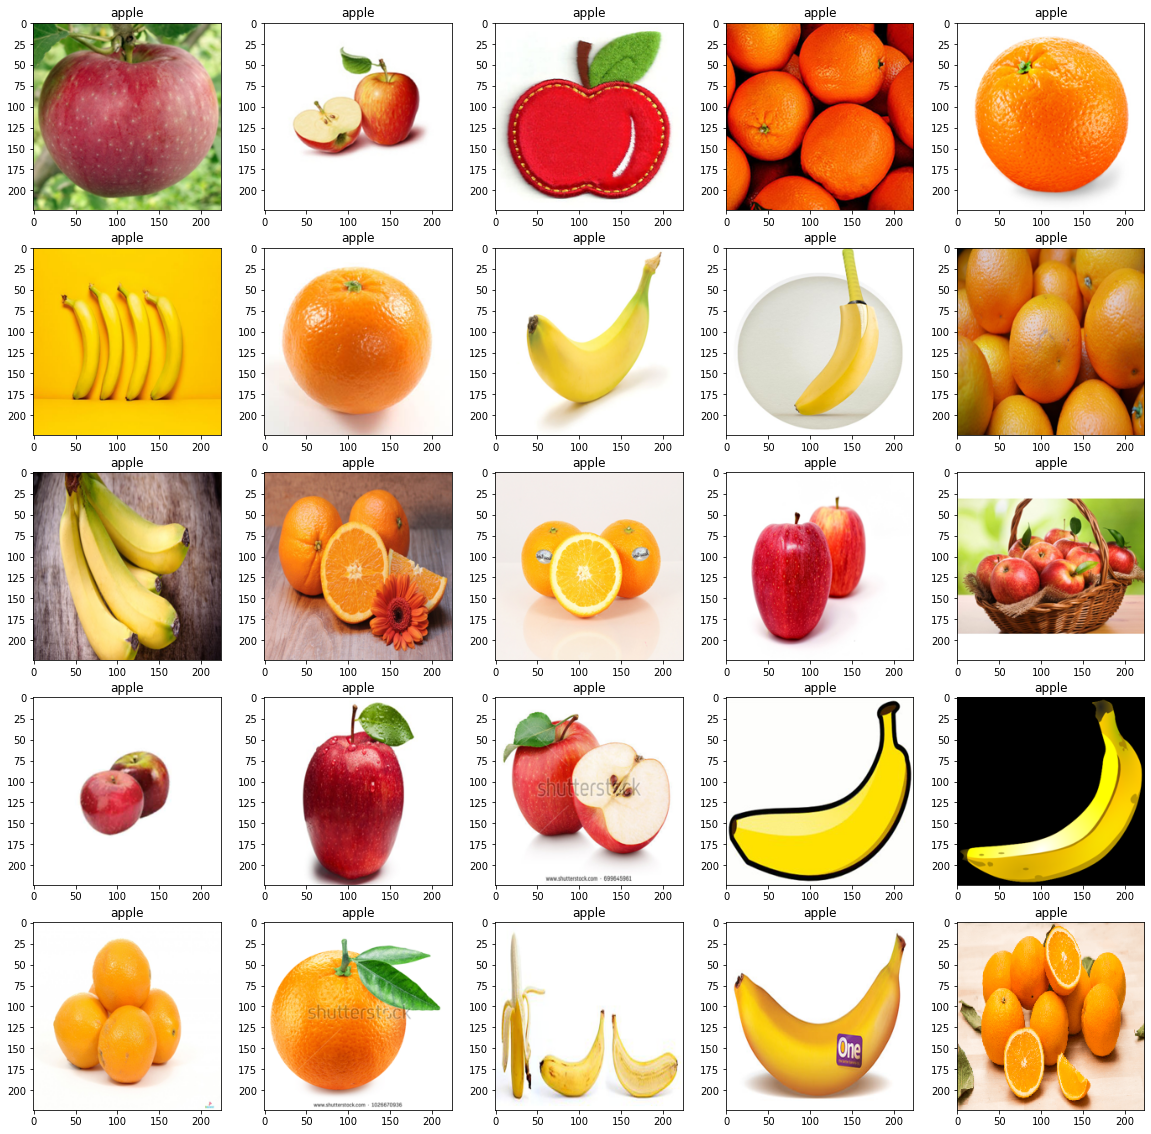

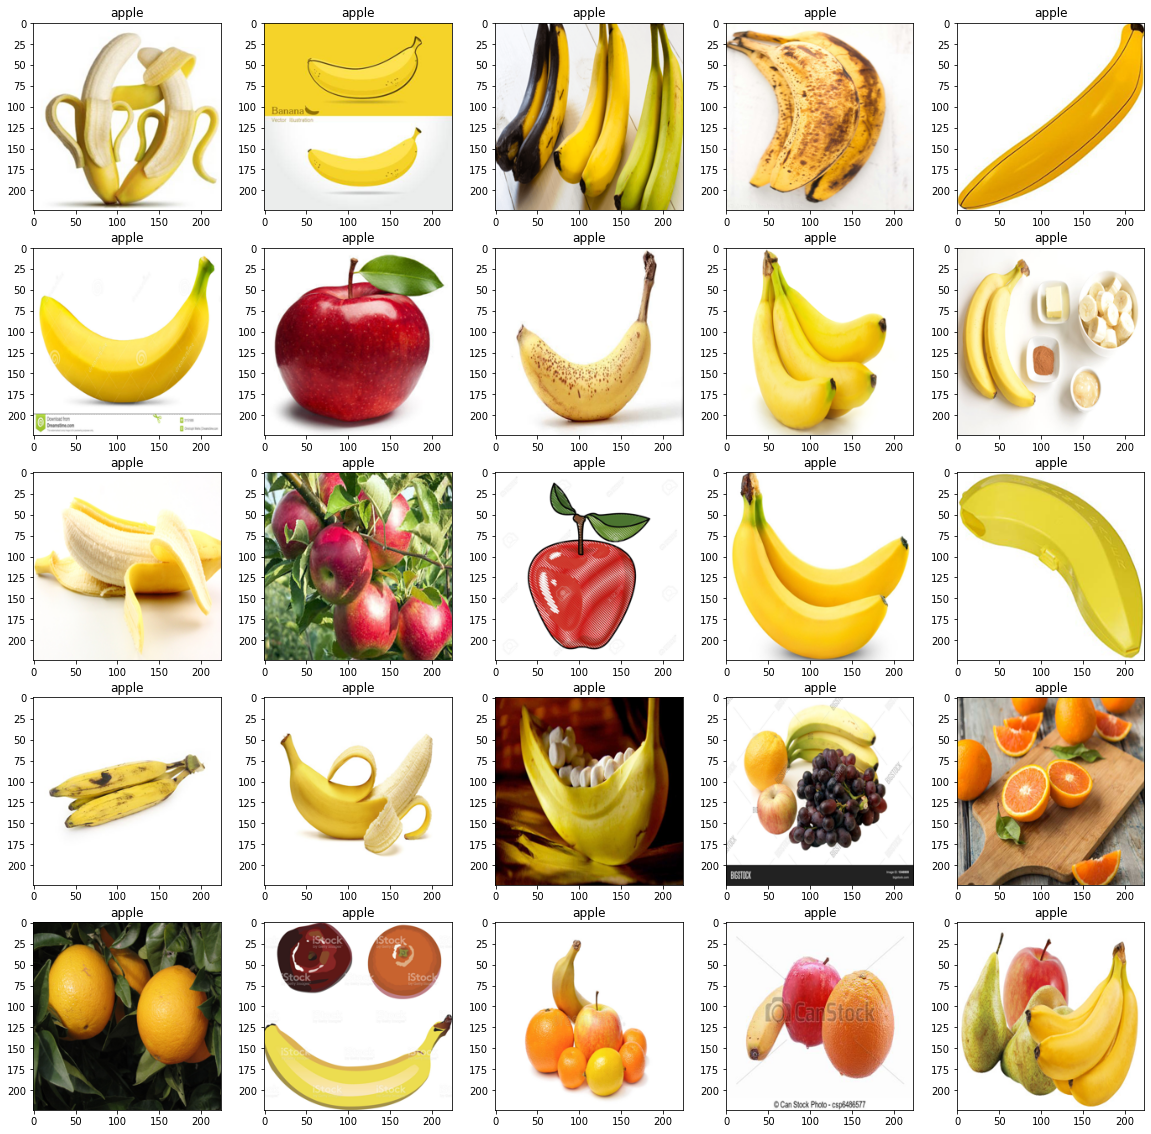

In [50]:
plot_summary_view(True)
plot_summary_view(False)

b. Prepare data for model fitting (normalize image data)
==

In [58]:
# normalize
x_train = x_train/255
x_test = x_test/255

2.Using ImageDataGenerator by Keras

In [72]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=20, shuffle=True, save_to_dir=train_path+"imgGen", save_format='jpg')
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=20, shuffle=True, save_to_dir=test_path+"imgGen", save_format='jpg')

Using CutMix

In [120]:
# from cutmix_keras import CutMixImageDataGenerator
# trainGen = ImageDataGenerator(
#     rotation_range = 40,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     rescale = 1./255,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     horizontal_flip = True)
#
# # flow from dataframe required for CutMix. same for MixUp
# trainGen1 = trainGen.flow(x=x_train, y=y_train, batch_size=15, shuffle=True, save_to_dir=train_path+"imgGen", save_format='jpg')
# trainGen2 = trainGen.flow(x=x_train, y=y_train, batch_size=15, shuffle=True, save_to_dir=train_path+"imgGen", save_format='jpg')
#
# testGen = ImageDataGenerator(rescale = 1./255)
# test_generator = testGen.flow(x=x_test, y=y_test, batch_size=15, shuffle=True, save_to_dir=test_path+"imgGen", save_format='jpg')
#
# train_generator = CutMixImageDataGenerator(
#         generator1=trainGen1,
#         generator2=trainGen2,
#         img_size=64,
#         batch_size=15
#     )



c. Build the model
==

In [212]:
#0.3 loss initially, kernel 5,5 and 9,9
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(7,7),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [62]:
# FOR LABEL ENCODED
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [64]:
# FOR ONE HOT ENCODED
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [186]:
# hist = model.fit(x_train, y_train, batch_size=10, epochs=100)

In [65]:
#if training using ImgDataGen
with tf.device('/device:GPU:0'):
    hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100)

Epoch 1/100


ValueError: in user code:

    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 7, 7, 512) are incompatible


d. Test our model
==

Observe the loss and accuracy over training

In [215]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 30ms/step - loss: 207.5205 - accuracy: 0.8167
207.52047729492188
0.8166667222976685


2021-11-25 23:28:11.654116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


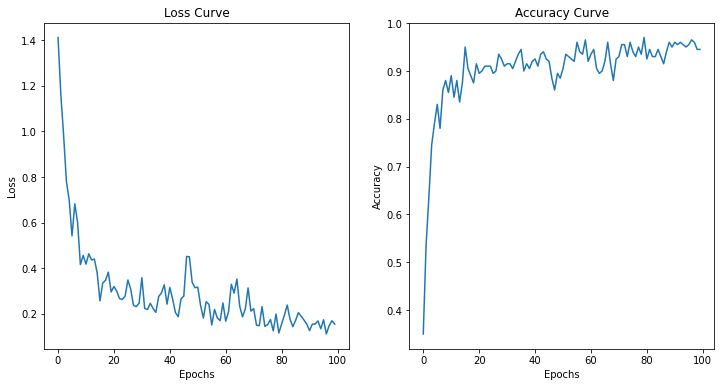

In [216]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

In [217]:
predictions = model.predict(x_test)

2021-11-25 23:28:21.369222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


e. Plot images with labels to show accuracy of predictions
==
1. Define function to plot image
2. Define function to plot bar chart to show relative probabilities


In [218]:
def plot_image(i, pred, true_label, test_img):
    plt.grid(False)
    plt.imshow(test_img[i])

    pred_label = np.argmax(pred[i])

    if pred_label == true_label[i]:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("predicted: {} {:2.0f}% (actual: {})".format(class_names[pred_label],
                                                           100*np.max(pred[i]),
                                                           class_names[true_label[i]]),
                                                           color=color)

In [219]:
def plot_probs(i, pred, true_label):
    plt.xticks(range(4), class_names, rotation=45)
    # cannot take argmax, must take other indices also. EXCEPT the pred.
    # np.delete abit inefficient time wise
    pred_arr = np.arange(0,4,1)
    pred_arr = np.delete(pred_arr, true_label[i])
    plot = plt.bar(range(4),pred[i])
    plt.ylim([0,1])

    for label in pred_arr:
        plot[label].set_color('red')
    plot[true_label[i]].set_color('green')

3. Plot test images with labels and probabilities of prediction

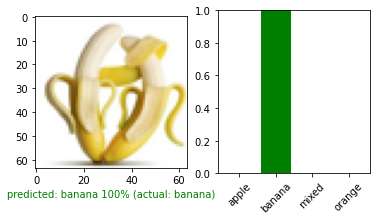

In [220]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(0, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_probs(0, predictions, y_test)
plt.show()

In [221]:
num_rows = 10
num_cols = 6
num_images = num_rows * num_cols

In [222]:
def plot_result():
# 2x figure size
    plt.figure(figsize=(2*num_rows, 2*2*num_cols))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions, y_test, x_test)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_probs(i, predictions, y_test)
    plt.tight_layout()
    plt.show()

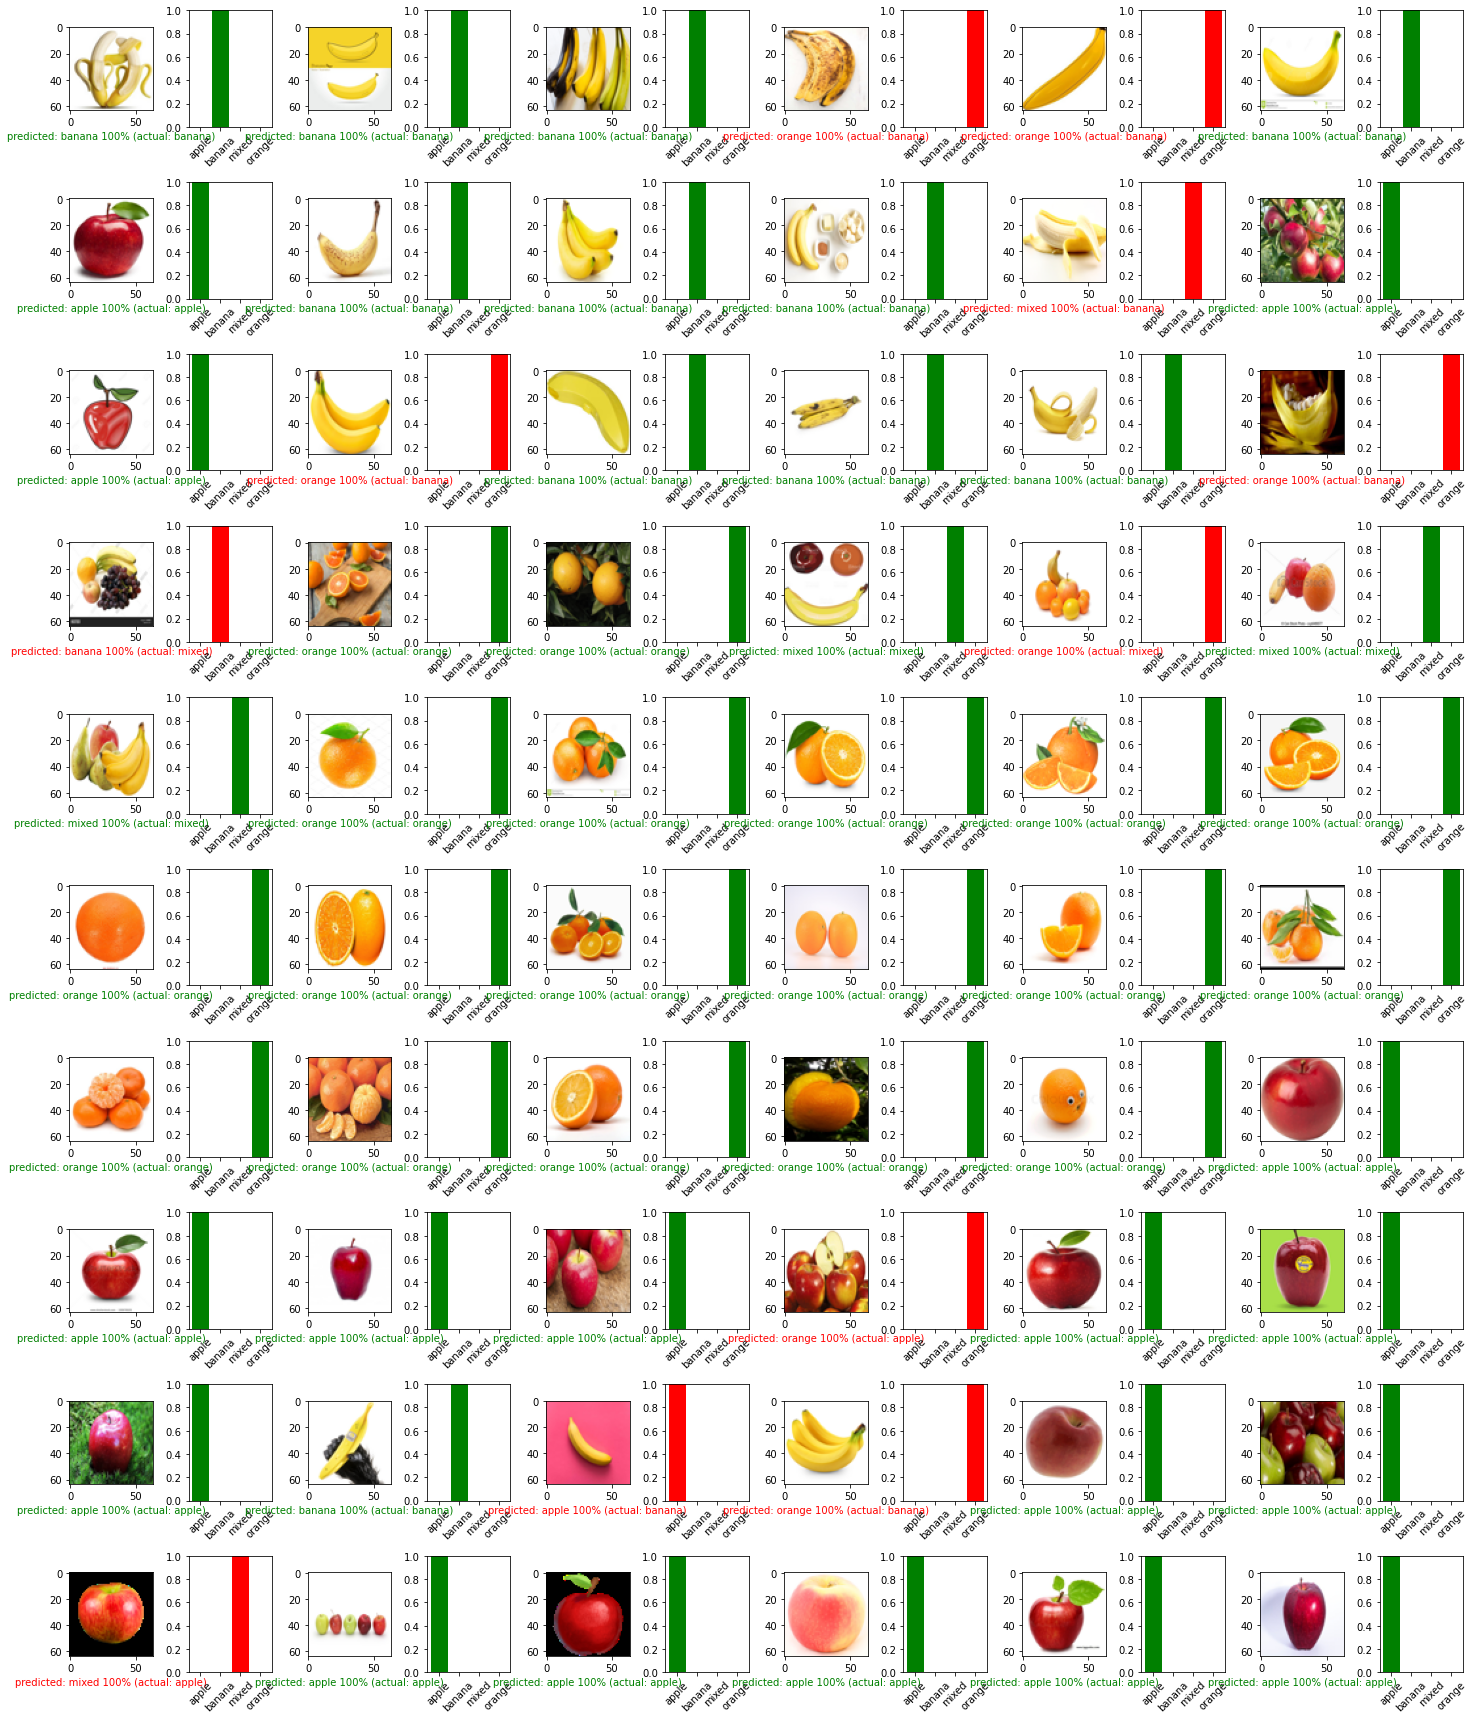

In [223]:
plot_result()
#explore early stopping, pipeline

In [ ]:
# data augmentation

In [176]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Using vgg16 model
==

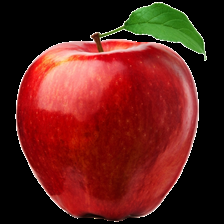

In [116]:
files_train = [img for img in glob.glob(train_path + "apple_1.jpg")]
x_train, y_train = process_image(files_train, train_path, 'resize')
# need to conver to array, only shows immage lol
x_train

In [103]:
from keras.applications.vgg16 import decode_predictions

x_train = tf.keras.applications.vgg16.preprocess_input(
    x_train, data_format=None
)
model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(x_resize, y_resize, 3),
    pooling=None,
    classes=len(class_names),
    classifier_activation="softmax",
)
x_train_vgg = np.expand_dims(x_train, axis=0)
features = model.predict(x_train_vgg)
p = decode_predictions(features)
p


TypeError: 'Image' object is not subscriptable

In [ ]:
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')